# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
# import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

# import grading_utils
# reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

We're using TF 1.10.0


Using TensorFlow backend.


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [2]:
# grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
#                         all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [3]:
# token expires every 30 min
COURSERA_TOKEN = "JcPWqzwVrcPuECQJ"
COURSERA_EMAIL = "hongng234@gmail.com"

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [4]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[ 0.          0.29803922  0.96470588  0.98823529  0.43921569]
 [ 0.          0.33333333  0.98823529  0.90196078  0.09803922]
 [ 0.          0.33333333  0.98823529  0.8745098   0.        ]
 [ 0.          0.33333333  0.98823529  0.56862745  0.        ]
 [ 0.          0.3372549   0.99215686  0.88235294  0.        ]]
A closeup of a sample patch:


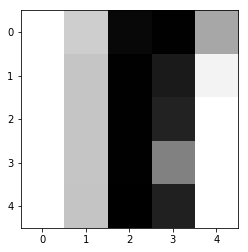

And the whole sample:


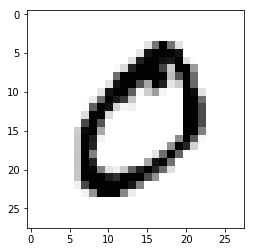

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [5]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [6]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [7]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]] [5 0 4]


In [8]:
# run this again if you remake your graph
s = reset_tf_session()

In [9]:
# Model parameters: W and b
W = tf.get_variable(name='W', shape=[784, 10], initializer=tf.contrib.layers.xavier_initializer()) ### tf.get_variable(...) with shape[0] = 784
b = tf.get_variable(name='b', shape=[1, 10], initializer=tf.contrib.layers.xavier_initializer()) ### tf.get_variable(...)

In [10]:
# Placeholders for the input data
input_X = tf.placeholder(dtype=tf.float32, shape=[None, 784]) ### tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_y = tf.placeholder(dtype=tf.float32, shape=[None, 10]) ### tf.placeholder(...) for one-hot encoded true labels

In [11]:
learning_rate = 0.001
# Compute predictions
logits = tf.add(tf.matmul(input_X, W), b) ### logits for input_X, resulting shape should be [input_X.shape[0], 10]
probas = tf.nn.softmax(logits=logits) ### apply tf.nn.softmax to logits
classes = tf.argmax(probas,1) ### apply tf.argmax to find a class index with highest probability

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y)) ### cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) ### optimizer step that minimizes the loss

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="data:image/jpeg;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAEgCAYAAADSVRDhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvpW3flQAAIABJREFUeJzs3Xl8TPfi//HXZCUbSRCJECRKxBLEdm1R11W02t6q6qJaWq3ltnXpfrXa6rf6u3RV7bXU1qKtUrrQRRvcaimlSrgVaxJbkF32fH5/TA0jiwRJTLyfj8c8Zs45n/mcz0l1Ju98lmMxxhhERERERESkwjlVdQNERERERESuFQpgIiIiIiIilUQBTEREREREpJIogImIiIiIiFQSBTAREREREZFKogAmIiIiIiJSSRTAREREREREKokCmIiIiIiISCVRABMREREREakkCmAiIiIiIiKVRAFMRERERESkkiiAiYiIiIiIVBIFMBERERERkUqiACYiIiIiIlJJFMBEREREREQqiQKYiIiIiIhIJVEAExERERERqSQKYCIiIiIiIpVEAUxERERERKSSKICJSLlZLBbi4uKquhkiIiIiDkcBTOQqk5%2BfX9VNuGzV4RpERByRMYbCwsKqboaIlEIBTKQSxcfH8/e//526devi7%2B/PuHHjmD9/Pt26dWP8%2BPH4%2BfkxefJkCgsLmTJlCiEhIdSrV497772X1NRUALKzs7nnnnvw9/endu3adOzYkePHjwMwf/58mjZtire3N02aNOHDDz8ssS179uyhb9%2B%2B%2BPn50bx5cz7%2B%2BGPbsfvuu4%2BxY8cycOBAvL296dy5M/v27QOgZ8%2BeALRt2xYvLy8%2B%2BugjYmJiCA4O5tVXX6V%2B/frcf//9AMyePZuwsDD8/PwYNGgQR44csZ3DYrHw1ltv0bRpU%2BrUqcPjjz9OYWEhOTk5%2BPn58fvvv9vKnjhxgpo1a5KUlHSF/kuIiFSsqVOnEhoaire3Ny1btmTFihW2Y7NnzyY8PNx27NdffwWK/44AmDx5Mvfcc4/t/QcPHsRisdj%2B2BUdHc2zzz5Lt27d8PDwYP/%2B/cybN892jqZNm/Kf//zHrn0rV64kMjISHx8fQkNDWbNmDZ988gkdOnSwKzd9%2BnRuueWWCvkZiVyzjIhUivz8fNOmTRvz2GOPmYyMDJOVlWU2bNhg5s2bZ5ydnc1bb71l8vLyzJkzZ8zcuXNNaGio2bdvn0lPTze33nqrueeee4wxxrz33nvmxhtvNJmZmSY/P99s2bLFpKammoyMDOPt7W327NljjDHmyJEjZufOncW2JSMjwwQHB5v333/f5OXlma1btxp/f39b%2BeHDhxtfX1%2BzadMmk5eXZ%2B666y5zxx132N4PmL1799q2f/jhB%2BPs7GyeeOIJk52dbc6cOWPWrl1r/P39zdatW012drYZN26c6dGjh10d0dHR5tSpU%2BbQoUOmWbNmZvbs2cYYY0aPHm2eeOIJW9k33njD3HjjjVfov4SISMX7%2BOOPTWJioikoKDBLly41Hh4e5siRI%2Bbjjz82QUFBZvPmzaawsNDs3bvXHDx4sMTvCGOMef75583dd99tq/vAgQMGMHl5ecYYY3r16mUaNmxodu7cafLy8kxubq754osvTFxcnCksLDQxMTGmZs2aZuvWrcYYYzZt2mR8fHzMN998YwoKCkxCQoLZvXu3yc7ONr6%2BviY2NtZ2rsjISLNs2bJK/MmJVH8KYCKVZOPGjaZOnTq2L8yz5s2bZxo2bGi37/rrrzfvvPOObXvPnj3GxcXF5OXlmblz55quXbua3377ze49GRkZplatWmbZsmXmzJkzpbZl6dKlpnv37nb7Ro0aZSZPnmyMsQawkSNH2o59%2BeWXpnnz5rbt4gKYq6urycrKsu0bMWKEefzxx23b6enpxsXFxRw4cMBWx%2BrVq23H33nnHXP99dcbY4z5%2BeefTXBwsCkoKDDGGNOhQwfz0UcflXpNIiJXs7Zt25rPPvvM/O1vfzNvvPFGkeMlfUcYU7YANmnSpFLPf/PNN9vOO2rUKPPYY48VW%2B7hhx82zzzzjDHGmJ07d5ratWub7Ozssl2kiJSJhiCKVJL4%2BHhCQkJwcXEpcqxhw4Z220eOHCEkJMS2HRISQn5%2BPsePH2fYsGH069ePoUOHEhQUxBNPPEFeXh6enp589NFHvPfeewQGBjJw4ED27NkDQEREBF5eXnh5ebFhwwYOHTrEpk2bqF27tu3x4YcfcuzYMds569evb3vt4eFBRkZGqddXt25datSoUeI1eHl54e/vT2JiYrHXHRISYhui2LlzZzw9PVm3bh179uwhLi6OQYMGlXp%2BEZGrycKFC4mMjLR9xu7cuZOTJ08SHx9PaGhokfKlfUeUxYXfI6tXr6ZLly74%2BflRu3ZtvvrqK06ePGk7V3FtABg%2BfDiLFy/GGMOiRYsYMmQI7u7ul9QmESmeAphIJWnYsCGHDx8udoEKi8Vitx0UFMShQ4ds24cPH8bFxYWAgABcXV15/vnniY2NZePGjXzxxRcsXLgQgH79%2BvHtt99y9OhRWrRowYMPPgjArl27yMjIICMjgx49etCwYUN69epFSkqK7ZGRkcG77757ydd3sWvIzMzk1KlTNGjQwLYvPj7e7hqDgoJs28OHD%2BeDDz5g0aJFDB482C7ciYhczQ4dOsSDDz7IjBkzOHXqFCkpKbRq1QpjDA0bNrTNqT1fad8Rnp6enDlzxrZ9/h/Lzjr/MzgnJ4fbbruNiRMncvz4cVJSUhgwYADGGNu5imsDQJcuXXBzc2PDhg0sXryYYcOGlfv6RaR0CmAilaRTp04EBgby1FNPkZmZSXZ2Nj/%2B%2BGOxZe%2B8805ef/11Dhw4QEZGBs888wx33HEHLi4u/PDDD/z%2B%2B%2B8UFBTg4%2BODq6srzs7OHD9%2BnFWrVpGZmYm7uzteXl44OzsXW/%2BNN97IH3/8waJFi8jLyyMvL49ffvmF3bt3l%2BlaAgIC2L9/f6ll7rrrLubNm8f27dvJycnhmWeeoXPnzjRu3NhW5t///jfJycnEx8fz5ptvcscdd9iODRs2jBUrVvDBBx9w7733lqldIiJXg8zMTCwWC3Xr1gVg3rx57Ny5E4AHHniAadOmsXXrVowxxMXFcejQoVK/IyIjI1m/fj2HDx8mNTWVV155pdTz5%2BbmkpOTQ926dXFxcWH16tV88803tuMjR45k3rx5rF27lsLCQhITE20jJgDuvfdexo0bh4uLC927d7/SPx6Ra54CmEglcXZ25vPPPycuLo5GjRoRHBzMRx99VGzZESNGMGzYMHr27EmTJk2oUaMGb7/9NmD9y%2BfgwYPx8fEhPDycXr16cc8991BYWMj06dMJCgrCz8%2BPdevWMXPmzGLr9/b25ptvvmHp0qUEBQVRv359nnzySXJycsp0LZMnT2b48OHUrl3bbvXE8/Xp04eXXnqJ2267jcDAQPbt28fSpUvtytx888106NCByMhIBg4cyMiRI23HgoODad%2B%2BPRaLhR49epSpXSIiV4OWLVsyYcIEunbtSkBAAL///jvdunUD4Pbbb%2BfZZ5/lrrvuwtvbm1tuuYXTp0%2BX%2Bh3Rt29f7rjjDtq0aUOHDh248cYbSz2/t7c3b731FkOGDMHX15fFixfbDePu1KkT8%2BbNY/z48dSqVYtevXrZjVgYNmwYO3fuVO%2BXSAWxmLP90SIilchisbB3717CwsJKLDNixAiCgoKYMmVKJbZMROTalpWVRb169fj1119p1qxZVTdHpNq5tJmeIiIV7ODBgyxfvpxt27ZVdVNERK4p7777Lh07dlT4EqkgCmAictWZN

In [13]:
s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})

0.25493246

In [14]:
accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))

0.93049999999999999

# Submit a linear model

In [ ]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
# grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([W, b, input_X, input_y, logits, probas, classes]))
# # Validation loss
# grader.set_answer("vmogZ", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# # Validation accuracy
# grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [ ]:
# you can make submission with answers so far to check yourself at this stage
# grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

# Adding more layers

Let's add a couple of hidden layers and see how that improves our validation accuracy.

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convinient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (rememeber that we need it for a hidden layer!).

Now add 2 hidden layers to the code above and restart training.
You're aiming for ~0.97 validation accuracy here.

In [16]:
learning_rate = 0.001
n_input = 784
n_classes = 10

#Placeholder
x = tf.placeholder(dtype=tf.float32, shape=[None, n_input])
y = tf.placeholder(dtype=tf.float32, shape=[None, n_classes])

hidden1 = tf.layers.dense(x, 256, activation=tf.nn.sigmoid)
hidden2 = tf.layers.dense(hidden1, 256, activation=tf.nn.sigmoid)

logits = tf.layers.dense(hidden2, 10)
probas = tf.nn.softmax(logits)
classes = tf.argmax(probas, 1)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels= y))
step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

s = tf.Session()

s.run(tf.global_variables_initializer())

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        
        _, batch_loss = s.run([step, loss], {x: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {x: X_val_flat, y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {x: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {x: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="data:image/jpeg;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAEgCAYAAADSVRDhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvpW3flQAAIABJREFUeJzs3XlcVNX/%2BPHXACoiO4qKgwriyqqgYilukWukaYr9XApNW/yU9sk%2Bmlnatz622Kfyo9nHJSw3NJc0t9zRNCU1F3JHUMANEJBF9vP748oosYQWy%2Bj7%2BXjcx8zce%2Bfcc4eZy7znnPM%2BOqWUQgghhBBCCCFEhTOp6goIIYQQQgghxKNCAjAhhBBCCCGEqCQSgAkhhBBCCCFEJZEATAghhBBCCCEqiQRgQgghhBBCCFFJJAATQgghhBBCiEoiAZgQQgghhBBCVBIJwIQQQgghhBCikkgAJoQQQgghhBCVRAIwIYQQQgghhKgkEoAJIYQQQgghRCWRAEwIIYQQQgghKokEYEIIIYQQQghRSSQAE0IIIYQQQohKIgGYEEIIIYQQQlQSCcCEEEIIIYQQopJIACaEEEIIIYQQlUQCMCGEEEIIIYSoJBKACSGEEEIIIUQlkQBMCHHfdDodFy5cqOpqCCGEEEIYHQnAhKhm8vLyqroKf9nDcA5CCGGMlFIUFBRUdTWEEGWQAEyIShQbG8szzzxDvXr1cHBwYPz48SxevJjHH3%2BciRMnYm9vz/Tp0ykoKOCDDz6gSZMmODo6MnLkSFJTUwHIyspi%2BPDhODg4YGtrS/v27bl%2B/ToAixcvxtXVFSsrK1xcXFi2bFmpdTlz5gyBgYHY29vTsmVLVq1aZdj2/PPP8%2Bqrr9KvXz%2BsrKzo2LEjUVFRAAQEBADg7e2NpaUlK1euZM%2BePej1ej7%2B%2BGMaNGjACy%2B8AMCCBQtwc3PD3t6eoKAgrly5YjiGTqdj9uzZuLq6UrduXSZNmkRBQQHZ2dnY29tz8uRJw743btygdu3aJCQk/E1/CSGEqFgfffQRzZo1w8rKijZt2rBu3TrDtgULFtC6dWvDtqNHjwIl/48AmD59OsOHDzc8PyYmBp1OZ/ixq1u3bkydOpXHH38cCwsLLl68SGhoqOEYrq6u/O9//ytSv/Xr1%2BPj44O1tTXNmjVj69atfP/99/j6%2BhbZ77PPPmPAgAEV8hoJ8chSQohKkZeXp7y8vNSECRNUenq6un37ttq3b58KDQ1Vpqamavbs2So3N1dlZmaqRYsWqWbNmqmoqCiVlpamBg4cqIYPH66UUurrr79W/fv3VxkZGSovL08dPnxYpaamqvT0dGVlZaXOnDmjlFLqypUrKjIyssS6pKenK71er7755huVm5urjhw5ohwcHAz7jxo1StnZ2alDhw6p3Nxc9dxzz6mhQ4cang%2Bo8%2BfPGx7v3r1bmZqaqrfeektlZWWpzMxMtXPnTuXg4KCOHDmisrKy1Pjx41WXLl2KlNGtWzeVlJSkLl26pJo3b64WLFiglFLq5ZdfVm%2B99ZZh3y%2B%2B%2BEL179//b/pLCCFExVu1apWKj49X%2Bfn5KiwsTFlYWKgrV66oVatWKScnJxUREaEKCgrU%2BfPnVUxMTKn/I5RS6r333lP/7//9P0PZ0dHRClC5ublKKaW6du2qnJ2dVWRkpMrNzVU5OTlq48aN6sKFC6qgoEDt2bNH1a5dWx05ckQppdShQ4eUtbW12rZtm8rPz1dxcXHq9OnTKisrS9nZ2alTp04ZjuXj46NWr15dia%2BcEA8/CcCEqCQHDhxQdevWNfzDLBQaGqqcnZ2LrOvRo4eaO3eu4fGZM2eUmZmZys3NVYsWLVKdOnVSx48fL/Kc9PR0ZWNjo1avXq0yMzPLrEtYWJjq3LlzkXVjx45V06dPV0ppAdjo0aMN2zZt2qRatmxpeFxSAFajRg11%2B/Ztw7qQkBA1adIkw%2BO0tDRlZmamoqOjDWVs2bLFsH3u3LmqR48eSimlDh48qPR6vcrPz1dKKeXr66tWrlxZ5jkJIUR15u3trX744Qf15JNPqi%2B%2B%2BKLY9tL%2BRyhVvgBs2rRpZR7/6aefNhx37NixasKECSXu99JLL6m3335bKaVUZGSksrW1VVlZWeU7SSFEuUgXRCEqSWxsLE2aNMHMzKzYNmdn5yKPr1y5QpMmTQyPmzRpQl5eHtevX2fEiBH06tWL4OBgnJyceOutt8jNzaVOnTqsXLmSr7/%2BmoYNG9KvXz/OnDkDgLu7O5aWllhaWrJv3z4uXbrEoUOHsLW1NSzLli3j2rVrhmM2aNDAcN/CwoL09PQyz69evXqYm5uXeg6WlpY4ODgQHx9f4nk3adLE0EWxY8eO1KlTh/DwcM6cOcOFCxcICgoq8/hCCFGdfPfdd/j4%2BBiusZGRkSQmJhIbG0uzZs2K7V/W/4jy%2BOP/kS1btuDv74%2B9vT22trZs3ryZxMREw7FKqgPAqFGjWL58OUoplixZwpAhQ6hVq9YD1UkIUTIJwISoJM7Ozly%2BfLnEBBU6na7IYycnJy5dumR4fPnyZczMzKhfvz41atTgvffe49SpUxw4cICNGzfy3XffAdCrVy%2B2b9/O1atXadWqFS%2B%2B%2BCIAv//%2BO%2Bnp6aSnp9OlSxecnZ3p2rUrKSkphiU9PZ158%2BY98Pn92TlkZGSQlJREo0aNDOtiY2OLnKOTk5Ph8ahRo1i6dClLlixh8ODBRYI7IYSozi5dusSLL77InDlzSEpKIiUlBQ8PD5RSODs7G8bU3qus/xF16tQhMzPT8PjeH8sK3XsNzs7OZtCgQbz55ptcv36dlJQU%2Bvbti1LKcKyS6gDg7%2B9PzZo12bdvH8uXL2fEiBH3ff5CiLJJACZEJenQoQMNGzZk8uTJZGRkkJWVxf79%2B0vcd9iwYXz%2B%2BedER0eTnp7O22%2B/zdChQzEzM2P37t2cPHmS/Px8rK2tqVGjBqamply/fp0NGzaQkZFBrVq1sLS0xNTUtMTy%2B/fvz7lz51iyZAm5ubnk5uby66%2B/cvr06XKdS/369bl48WKZ%2Bzz33HOEhoZy7NgxsrOzefvtt%2BnYsSNNmzY17PPpp5%2BSnJxMbGwsX375JUOHDjVsGzFiBOvWrWPp0qWMHDmyXPUSQojqICMjA51OR7169QAIDQ0lMjISgDFjxjBr1iyOHDmCUooLFy5w6dKlMv9H%2BPj4sHfvXi5fvkxqaiozZ84s8/g5OTlkZ2dTr149zMzM2LJlC9u2bTNsHz16NKGhoezcuZOCggLi4%2BMNPSYARo4cyfjx4zEzM6Nz585/98sjxCNPAjAhKompqSk//vgjFy5coHHjxuj1elauXFniviEhIYwYMYKAgABcXFwwNzfnv//9L6D98jl48GCsra1p3bo1Xbt2Zfjw4RQUFPDZZ5/h5OSEvb094eHhfPXVVyWWb2VlxbZt2wgLC8PJyYkGDRrwr3/9i%2Bzs7HKdy/Tp0xk1ahS2trZFsifeq2fPnvzf//0fgwYNomHDhkRFRREWFlZkn6effhpfX198fHzo168fo0ePNmzT6/W0a9cOnU5Hly5dylUvIYSoDtq0acM///lPOnXqRP369Tl58iSPP/44AM8%2B%2ByxTp07lueeew8rKigEDBnDz5s0y/0cEBgYydOhQvLy88PX1pX///mUe38rKitmzZzNkyBDs7OxYvnx5kW7cHTp0IDQ0lIkTJ2JjY0PXrl2L9FgYMWIEkZGR0volRAXRqcL2aCGEqEQ6nY7z58/j5uZW6j4hISE4OTnxwQcfVGLNhBDi0Xb79m0cHR05evQozZs3r%2BrqCPHQebCRnkIIUcFiYmJYu3Ytv/32W1V

In [17]:
# you can write the code here to get a new `step` operation and then run cells with training loop above
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety
#Params
learning_rate = 0.001
EPOCHS = 40
BATCH_SIZE = 128
display_step = 10

#Network parameters
n_hidden_1 = 256 #256 neurons in hidden layer 1
n_hidden_2 = 256 #256 neurons in hidden layer 2
n_input = 784    #Input features (imageshape 28*28*1 )
n_classes = 10   #Number digits label 0->9

#Placeholder
x = tf.placeholder(dtype=tf.float32, shape=[None, n_input])
y = tf.placeholder(dtype=tf.float32, shape=[None, n_classes])

#Weights & biases of each layer
stddev = 0.1

W = {
    'h1': tf.Variable(tf.random_normal(shape=[n_input, n_hidden_1], stddev=stddev)),
    'h2': tf.Variable(tf.random_normal(shape=[n_hidden_1, n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal(shape=[n_hidden_2, n_classes], stddev=stddev))
}

b = {
    'b1': tf.Variable(tf.random_normal(shape=[n_hidden_1])),
    'b2': tf.Variable(tf.random_normal(shape=[n_hidden_2])),
    'out': tf.Variable(tf.random_normal(shape=[n_classes]))
}

In [18]:
def multilayer_perceptron(x, weights, biases):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    return tf.matmul(layer_2, weights['out']) + biases['out']



#Predicton function
logits = multilayer_perceptron(x, W, b)

#Loss and Optimizer function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

#Correct prediction and Accuracy function
probas = tf.nn.softmax(logits=logits) ### apply tf.nn.softmax to logits
classes = tf.argmax(probas,1) ### apply tf.argmax to find a class index with highest probability
# classes = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

In [19]:
s = tf.Session()

s.run(tf.global_variables_initializer())

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        
        _, batch_loss = s.run([step, loss], {x: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {x: X_val_flat, y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {x: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {x: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="data:image/jpeg;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAEgCAYAAADSVRDhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvpW3flQAAIABJREFUeJzs3X1czXf/wPHX6YakdOeuHHITlqiWcjOEYRGLjRGGLeZydw3XNYxtbnbZz2x22czNxjY2Q%2B5mbMOMRq4Ziblp7mKVEqlWKd2dOp/fH2cdmkozlcP7%2BXicR%2Bec7/d8vu/vV87pfT6fz/ujUUophBBCCCGEEEJUOLOqDkAIIYQQQgghHhWSgAkhhBBCCCFEJZEETAghhBBCCCEqiSRgQgghhBBCCFFJJAETQgghhBBCiEoiCZgQQgghhBBCVBJJwIQQQgghhBCikkgCJoQQQgghhBCVRBIwIYQQQgghhKgkkoAJIYQQQgghRCWRBEwIIYQQQgghKokkYEIIIYQQQghRSSQBE0IIIYQQQohKIgmYEEIIIYQQQlQSScCEEEIIIYQQopJIAiaEEEIIIYQQlUQSMCGEEEIIIYSoJJKACSGEEEIIIUQlkQRMCCGEEEIIISqJJGBCiL9Mo9Fw8eLFqg5DCCGEEMLkSAImxAOmoKCgqkP42x6GcxBCCFOklEKv11d1GEKIMkgCJkQlio%2BP59lnn6VOnTo4OTkxadIk1qxZQ6dOnZg6dSqOjo7MnTsXvV7P/PnzcXV1pW7duowcOZKMjAwAcnNzef7553FycsLe3h4/Pz%2BSkpIAWLNmDU2bNsXW1pYmTZqwbt26UmM5d%2B4cvXr1wtHRkZYtW7Jp0ybjthdeeIGJEyfSt29fbG1tad%2B%2BPZcuXQLA398fAC8vL2xsbNi4cSP79%2B9Hq9WycOFC6tevz4svvgjAqlWrcHNzw9HRkaCgIBITE43H0Gg0LFmyhKZNm1K7dm2mTZuGXq8nLy8PR0dHTp8%2Bbdz3%2BvXr1KhRg%2BTk5Pv0LyGEEBXr7bffplmzZtja2tKqVSu2bdtm3LZq1Src3d2N244fPw6U/BkBMHfuXJ5//nnj62NjY9FoNMYvu7p168Zrr71Gp06dsLa25rfffmP16tXGYzRt2pSPP/64WHzbt2/H29ubWrVq0axZM3bv3s3mzZtp27Ztsf3ee%2B89BgwYUCHXSIhHlhJCVIqCggLl6emppkyZorKyslROTo46ePCgWr16tTI3N1dLlixROp1OZWdnq08//VQ1a9ZMXbp0SWVmZqpnnnlGPf/880oppT766CPVr18/dfPmTVVQUKAiIyNVRkaGysrKUra2turcuXNKKaUSExNVVFRUibFkZWUprVarPvvsM6XT6dSxY8eUk5OTcf9Ro0YpBwcHdeTIEaXT6dSwYcPUkCFDjK8HVHR0tPHxjz/%2BqMzNzdX06dNVbm6uys7OVvv27VNOTk7q2LFjKjc3V02aNEl16dKlWBvdunVTqampKi4uTjVv3lytWrVKKaXU%2BPHj1fTp0437vv/%2B%2B6pfv3736V9CCCEq3qZNm9SVK1dUYWGhCg0NVdbW1ioxMVFt2rRJubi4qIiICKXX61V0dLSKjY0t9TNCKaXmzJmjhg8fbmw7JiZGAUqn0ymllOratatq2LChioqKUjqdTuXn56tvv/1WXbx4Uen1erV//35Vo0YNdezYMaWUUkeOHFG1atVSe/bsUYWFhSohIUGdPXtW5ebmKgcHB3XmzBnjsby9vdWWLVsq8coJ8fCTBEyISnLo0CFVu3Zt4wdmkdWrV6uGDRsWe%2B7JJ59Uy5YtMz4%2Bd%2B6csrCwUDqdTn366aeqY8eO6uTJk8Vek5WVpezs7NSWLVtUdnZ2mbGEhoaqzp07F3tu7Nixau7cuUopQwI2evRo47bvvvtOtWzZ0vi4pATM0tJS5eTkGJ8LCQlR06ZNMz7OzMxUFhYWKiYmxtjGrl27jNuXLVumnnzySaWUUocPH1ZarVYVFhYqpZRq27at2rhxY5nnJIQQDzIvLy/19ddfq6eeekq9//77d2wv7TNCqfIlYG%2B88UaZx%2B/fv7/xuGPHjlVTpkwpcb9x48apWbNmKaWUioqKUvb29io3N7d8JymEKBcZgihEJYmPj8fV1RULC4s7tjVs2LDY48TERFxdXY2PXV1dKSgoICkpiREjRhAQEEBwcDAuLi5Mnz4dnU5HzZo12bhxIx999BHOzs707duXc%2BfOAeDh4YGNjQ02NjYcPHiQuLg4jhw5gr29vfG2bt06rl27Zjxm/fr1jfetra3Jysoq8/zq1KmDlZVVqedgY2ODk5MTV65cKfG8XV1djUMU27dvT82aNTlw4ADnzp3j4sWLBAUFlXl8IYR4kHzxxRd4e3sb32OjoqJISUkhPj6eZs2a3bF/WZ8R5fHnz5Fdu3bRoUMHHB0dsbe3Z%2BfOnaSkpBiPVVIMAKNGjWL9%2BvUopVi7di2DBw%2BmevXq9xSTEKJkkoAJUUkaNmzI5cuXSyxQodFoij12cXEhLi7O%2BPjy5ctYWFhQr149LC0tmTNnDmfOnOHQoUN8%2B%2B23fPHFFwAEBATwww8/cPXqVR577DFeeuklAH799VeysrLIysqiS5cuNGzYkK5du5Kenm68ZWVlsWLFins%2Bv7udw82bN0lNTaVBgwbG5%2BLj44udo4uLi/HxqFGj%2BPLLL1m7di2DBg0qltwJIcSDLC4ujpdeeomlS5eSmppKeno6rVu3RilFw4YNjXNqb1fWZ0TNmjXJzs42Pr79y7Iit78H5%2BXlMXDgQF555RWSkpJIT08nMDAQpZTxWCXFANChQweqVavGwYMHWb9%2BPSNGjPjL5y%2BEKJskYEJUknbt2uHs7Myrr77KzZs3yc3N5aeffipx36FDh7J48WJiYmLIyspi1qxZDBkyBAsLC3788UdOnz5NYWEhtWrVwtLSEnNzc5KSktixYwc3b96kevXq2NjYYG5uXmL7/fr148KFC6xduxadTodOp%2BPo0aOcPXu2XOdSr149fvvttzL3GTZsGKtXr%2BbEiRPk5eUxa9Ys2rdvT%2BPGjY37vPvuu6SlpREfH88HH3zAkCFDjNtGjBjBtm3b%2BPLLLxk5cmS54hJCiAfBzZs30Wg01KlTB4DVq1cTFRUFwJgxY1i0aBHHjh1DKcXFixeJi4sr8zPC29ub8PBwLl%2B%2BTEZGBgsWLCjz%2BPn5%2BeTl5VGnTh0sLCzYtWsXe/bsMW4fPXo0q1evZt%2B%2Bfej1eq5cuWIcMQEwcuRIJk2ahIWFBZ07d77fl0eIR54kYEJUEnNzc7755hsuXrxIo0aN0Gq1bNy4scR9Q0JCGDFiBP7%2B/jRp0gQrKys%2B/PBDwPDN56BBg6hVqxbu7u507dqV559/Hr1ez3vvvYeLiwuOjo4cOHCA5cuXl9i%2Bra0te/bsITQ0FBcXF%2BrXr8%2BMGTPIy8sr17nMnTuXUaNGYW9vX6x64u169OjBf/7zHwYOHIizszOXLl0iNDS02D79%2B/enbdu2eHt707dvX0aPHm3cptVq8fHxQaPR0KVLl3LFJYQQD4JWrVrx73//m44dO1KvXj1Onz5Np06dAHjuued47bXXGDZsGLa2tgwYMIDff/%2B9zM%2BIXr16MWTIEDw9PWnbti39%2BvUr8/i2trYsWbKEwYMH4%2BDgwPr164sN427Xrh2rV69m6tSp2NnZ0bVr12IjFkaMGEFUVJT0fglRQTSqqD9aCCEqkUajITo6Gjc3t1L3CQkJwcXFhfnz51diZEII8WjLycmhbt26HD9%2BnObNm1d1OEI8dO5tpqcQQlSw2NhYvvrqK3755ZeqDkUIIR4pK1aswM/PT

In [20]:
s.run(loss, {x: X_val_flat, y: y_val_oh})

0.096485376

In [21]:
accuracy_score(y_val, s.run(classes, {x: X_val_flat}))

0.98280000000000001

# Submit a 2-layer MLP
Run these cells after training a 2-layer MLP

In [ ]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
# grader.set_answer("i8bgs", s.run(loss, {x: X_val_flat, y: y_val_oh}))
# Validation accuracy for MLP
# grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {x: X_val_flat})))

In [ ]:
# you can make submission with answers so far to check yourself at this stage
# grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)